# Direct Model
## Setup

In [35]:
from data_utils import *
from train import * 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

EDIBILITY = False
FINAL = True

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    
else:
    device = torch.device('cpu')

dtype = torch.float32
torch.backends.cudnn.benchmark = True

print('use cuda = ', torch.cuda.is_available())
print('using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
use cuda =  True
using device: cuda


## Load Dataset

In [36]:
# fname = "bolete.h5"
fname = "bolete_lowres.h5"
data = load_bolete_data(fname)

print()
for k in data.keys():
    print(k, np.shape(data[k]))

ItemsViewHDF5(<HDF5 file "bolete_lowres.h5" (mode r)>)

bolete-characteristics (38, 1868)
bolete-edibility (5, 1868)
bolete-images (3, 256, 256, 1868)
bolete-labels (1868,)


## Split into train and test

In [37]:
if EDIBILITY:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-edibility")
    M = Y_train.shape[1]
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)
    
else:
    X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, "bolete-labels")
    M = np.size(np.unique(Y_train))

N, H, W, C = X_train.shape

Y_train = Y_train.astype(np.long)
Y_test = Y_test.astype(np.long)

## Define models

In [38]:
def simple_model():
    # copy final model from ass igment 2
    def flatten(x):
        """Flattens to [N, -1] where -1 is whatever it needs to be"""
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  
        # "flatten" the C * H * W values into a single vector per image
    class Flatten(nn.Module):
        def forward(self, x):
            return flatten(x)

    channel_1 = 32
    channel_2 = 24
    channel_3 = 16
    hidden_dim = 150
    learning_rate = 3e-3 # 1e-2

    model = nn.Sequential(
        nn.Conv2d(C, channel_1, kernel_size=5, padding=2),
        # nn.GroupNorm(4,channel_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_3),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.Dropout(0.1),
        Flatten(),
        nn.Linear(channel_3 * H * W, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, M)
    )
    
    return model

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

def modified_alexnet():
    model = models.alexnet(pretrained=True)
    model = freeze(model)

    # model.classifier[0] = ???
    model.classifier[6] = nn.Linear(in_features=4096, out_features=M, bias=True)
    # print(model)
    return model

def modified_googlenet():
    model = models.googlenet(pretrained=True)
    model = freeze(model)

    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(in_features=fc_in_feats, out_features=M, bias=True)
    # print(model)
    return model

def modified_resnext():
    model = models.resnext101_32x8d(pretrained=True)
    model = freeze(model)
    
    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, M)
    return model

## Define the loss function

In [39]:
loss_fn = nn.CrossEntropyLoss()

def pred_fn(scores):
    m = nn.Softmax(dim=1)
    return torch.argmax(m(scores), dim=1)

## Cross Validate on training data

In [40]:
# model = simple_model()
# model = modified_alexnet()
model = modified_googlenet()
# model = modified_resnext()


if EDIBILITY:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=5e-4,
        momentum=0.4,
        alpha=0.99
        )
else:
    optimizer = optim.RMSprop(
        model.parameters(),
        lr=1e-3,
        momentum=0.4,
        alpha=0.99
        )

transform = T.Compose([T.ToTensor()])

batch_size = 8
num_epochs = 40

torch.manual_seed(0)
history = cross_val(
    X_train=X_train,
    Y_train=Y_train,
    y_train=y_train,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    pred_fn=pred_fn,
    batch_size=batch_size,
    num_epochs=num_epochs,
    show_every=1,
    folds=1,
    test_size=0.2,
    device=device,
    dtype=dtype,
    transform=transform,
)

CV model on:  cuda
CV Fold:  1
Training model on:  cuda
Iter: 0
train Loss: 1.2871 Acc: 0.5060
Iter: 1
val Loss: 1.1759 Acc: 0.5508
Iter: 2
train Loss: 1.1701 Acc: 0.5529
Iter: 3
val Loss: 1.3214 Acc: 0.5455
Iter: 4
train Loss: 1.1432 Acc: 0.5663
Iter: 5
val Loss: 1.1722 Acc: 0.5508
Iter: 6
train Loss: 1.1191 Acc: 0.5542
Iter: 7
val Loss: 1.1658 Acc: 0.5508
Iter: 8
train Loss: 1.0741 Acc: 0.5689
Iter: 9
val Loss: 1.1984 Acc: 0.5508
Iter: 10
train Loss: 1.0516 Acc: 0.5622
Iter: 11
val Loss: 1.2393 Acc: 0.5508
Iter: 12
train Loss: 1.0283 Acc: 0.5837
Iter: 13
val Loss: 1.1655 Acc: 0.5401
Iter: 14
train Loss: 1.0373 Acc: 0.5730
Iter: 15
val Loss: 1.2144 Acc: 0.5561
Iter: 16
train Loss: 1.0130 Acc: 0.5944
Iter: 17
val Loss: 1.1802 Acc: 0.5187
Iter: 18
train Loss: 1.0055 Acc: 0.5837
Iter: 19
val Loss: 1.1645 Acc: 0.5508
Iter: 20
train Loss: 1.0066 Acc: 0.5756
Iter: 21
val Loss: 1.1747 Acc: 0.5401
Iter: 22
train Loss: 0.9879 Acc: 0.6212
Iter: 23
val Loss: 1.1944 Acc: 0.5508
Iter: 24
train Los

## Plot Training History

True

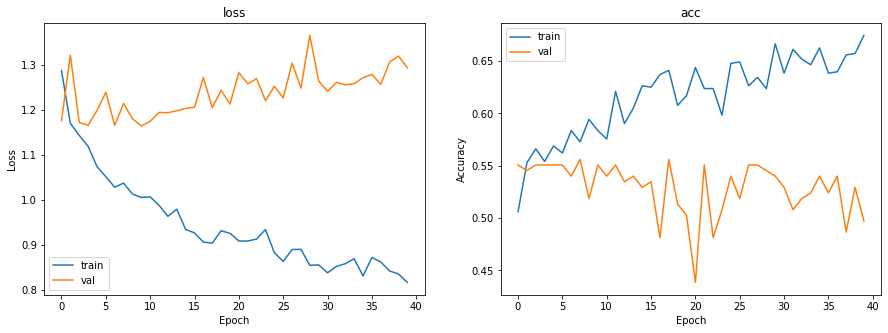

In [41]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0

phase = ["train", "val"]
for s in ["loss", "acc"]:
    for a in phase:
        axes[plotnum].set_title(s)
        axes[plotnum].set_xlabel("Epoch")
        axes[plotnum].plot(np.mean(history[a+'_'+s], axis=0))
        axes[plotnum].legend(phase)
    plotnum += 1
save_history_data(history, "direct_"+fname, edibility=EDIBILITY)

## Train on all the data

In [42]:
if FINAL:
    model = modified_googlenet()
    dataloader_tr = get_loader(X_train, Y_train, batch_size, transform)
    dataloader_val = get_loader(X_test, Y_test, batch_size, transform)
    dataloaders = {"train":dataloader_tr, "val":dataloader_val}
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(
        model,
        optimizer,
        dataloaders,
        loss_fn,
        pred_fn,
        num_epochs,
        show_every=1,
        device=device,
        dtype=dtype,
        phases=["train", "val"],
    )
    history = {
        "train_acc": train_acc_history,
        "train_loss": train_loss_history,
        "val_acc": val_acc_history,
        "val_loss": val_loss_history,
    }
    save_history_data(history, "direct_"+fname, edibility=EDIBILITY)

Training model on:  cuda
Iter: 0
train Loss: 1.6514 Acc: 0.1692
Iter: 1
val Loss: 1.6397 Acc: 0.1595
Iter: 2
train Loss: 1.6470 Acc: 0.1692
Iter: 3
val Loss: 1.6312 Acc: 0.1745
Iter: 4
train Loss: 1.6542 Acc: 0.1756
Iter: 5
val Loss: 1.6367 Acc: 0.1638
Iter: 6
train Loss: 1.6585 Acc: 0.1638
Iter: 7
val Loss: 1.6356 Acc: 0.1713
Iter: 8
train Loss: 1.6480 Acc: 0.1542
Iter: 9
val Loss: 1.6392 Acc: 0.1595
Iter: 10
train Loss: 1.6498 Acc: 0.1456
Iter: 11
val Loss: 1.6472 Acc: 0.1445
Iter: 12
train Loss: 1.6574 Acc: 0.1585
Iter: 13
val Loss: 1.6339 Acc: 0.1627
Iter: 14
train Loss: 1.6496 Acc: 0.1767
Iter: 15
val Loss: 1.6325 Acc: 0.1734
Iter: 16
train Loss: 1.6501 Acc: 0.1606
Iter: 17
val Loss: 1.6420 Acc: 0.1563
Iter: 18
train Loss: 1.6545 Acc: 0.1585
Iter: 19
val Loss: 1.6334 Acc: 0.1724
Iter: 20
train Loss: 1.6477 Acc: 0.1649
Iter: 21
val Loss: 1.6385 Acc: 0.1606
Iter: 22
train Loss: 1.6519 Acc: 0.1435
Iter: 23
val Loss: 1.6411 Acc: 0.1585
Iter: 24
train Loss: 1.6504 Acc: 0.1499
Iter: 25


ValueError: If using all scalar values, you must pass an index

## Evaluate 

In [9]:
if FINAL:
    X, Y, y = X_test, Y_test, y_test
else:
    X, Y, y = get_val(X_train, Y_train, y_train)

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    M,
    pred_fn,
    device=device,
    transform=None,
)
if EDIBILITY:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_ed_"+fname)
else:
    save_raw_eval_data(scores, y_pred, y_true, y_labels, "direct_"+fname)

Evaluating model on:  cuda


### Check status of GPU Memory for Debugging Purposes

In [10]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([192, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([192])
<class 'torch.nn.parameter.Parameter'> torch.Size([192])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 192, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 256, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 256, 1, 1])
<class 'torch.nn.parameter.Parameter